In [6]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import pyccl as ccl

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from scipy.optimize import least_squares

plt.style.use("seaborn-darkgrid")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
params = {'h': 0.6732,
        'Omega_cdm': 0.265, #0.27
        'Omega_b': 0.050,
        'n_s': 0.9665 }#

#cosmo_ccl = ccl.Cosmology(param_dict)
classy = ccl.boltzmann.classy.Class()
classy.set({ 'output':'mPk', 'P_k_max_h/Mpc': 100, 'z_max_pk': 1083})
classy.set(params)
classy.compute()

In [3]:
dz_f = 0.01
z_arr_f = np.arange(0.0, 2.5+dz_f, dz_f)
a_arr_f = 1/(1+z_arr_f) 
x_arr_f = np.log(a_arr_f)

In [4]:
dz_ext = 0.1
z_arr_ext = np.arange(2.5, 1082.5+dz_ext, dz_ext)
a_arr_ext = 1/(1+z_arr_ext) 
x_arr_ext = np.log(a_arr_ext)

In [5]:
len_f = len(z_arr_f)
len_ext = len(z_arr_ext)

In [6]:
z_arr = np.concatenate([z_arr_f, z_arr_ext])
a_arr = np.concatenate([a_arr_f, a_arr_ext]) 
x_arr = np.concatenate([x_arr_f, x_arr_ext])

In [7]:
H_arr = np.array([])
dM_arr = np.array([])
f_arr = np.array([])
s8_arr = np.array([])
for z in z_arr: 
            #We can worry about the rs_drag later
            dM = classy.angular_distance(z)*(1+z)
            H = classy.Hubble(z)
            f = classy.growthrate_at_z(z)
            s8 = classy.sigma(8./classy.h(),z)
            s8_arr = np.append(s8_arr, s8)
            H_arr = np.append(H_arr, H)
            f_arr = np.append(f_arr, f)
            dM_arr = np.append(dM_arr, dM)
H0 = classy.Hubble(0)

# dM

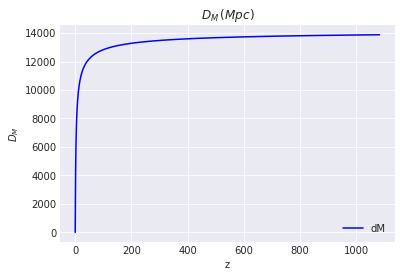

In [8]:
plt.plot(z_arr, dM_arr, 'b-', label='dM')
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

In [16]:
H_arr[2:len_f]

array([0.00022671, 0.00022781, 0.00022893, 0.00023006, 0.00023122,
       0.00023238, 0.00023356, 0.00023476, 0.00023598, 0.00023721,
       0.00023845, 0.00023971, 0.00024099, 0.00024229, 0.00024359,
       0.00024492, 0.00024626, 0.00024761, 0.00024899, 0.00025037,
       0.00025177, 0.00025319, 0.00025462, 0.00025607, 0.00025753,
       0.00025901, 0.0002605 , 0.00026201, 0.00026353, 0.00026506,
       0.00026661, 0.00026818, 0.00026976, 0.00027135, 0.00027296,
       0.00027458, 0.00027622, 0.00027787, 0.00027954, 0.00028121,
       0.00028291, 0.00028461, 0.00028633, 0.00028806, 0.00028981,
       0.00029157, 0.00029334, 0.00029513, 0.00029693, 0.00029874,
       0.00030057, 0.00030241, 0.00030426, 0.00030613, 0.000308  ,
       0.00030989, 0.0003118 , 0.00031371, 0.00031564, 0.00031758,
       0.00031953, 0.00032149, 0.00032347, 0.00032546, 0.00032746,
       0.00032947, 0.0003315 , 0.00033353, 0.00033558, 0.00033764,
       0.00033971, 0.00034179, 0.00034388, 0.00034599, 0.00034

In [9]:
dM_gp = np.zeros_like(z_arr)
dM_gp[1:len_f] = dz_f*np.cumsum(1/H_arr[1:len_f])
dM_gp[len_f:] = dz_ext*np.cumsum(1/H_arr[len_f:])+dM_gp[len_f-1]

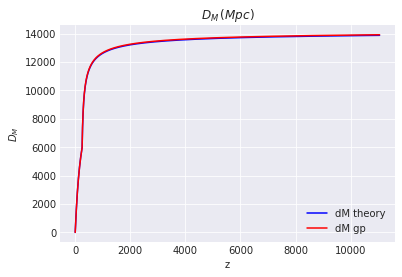

In [10]:
plt.plot(dM_arr, 'b-', label='dM theory')
plt.plot(dM_gp, 'r-', label='dM gp')
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

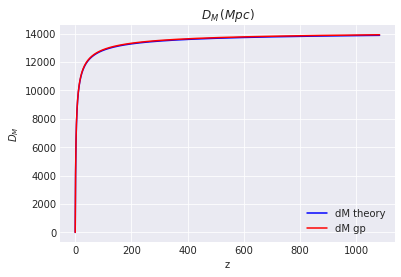

In [11]:
plt.plot(z_arr, dM_arr, 'b-', label='dM theory')
plt.plot(z_arr, dM_gp, 'r-', label='dM gp')
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

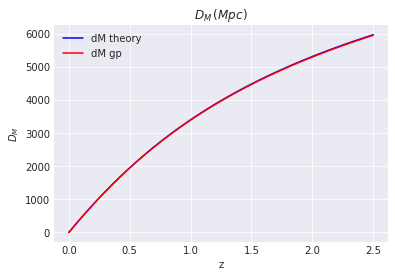

In [12]:
plt.plot(z_arr[:len_f], dM_arr[:len_f], 'b-', label='dM theory')
plt.plot(z_arr[:len_f], dM_gp[:len_f], 'r-', label='dM gp')
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

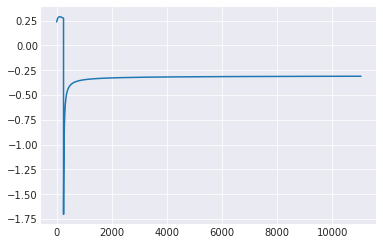

In [13]:
plt.plot(100*(dM_arr-dM_gp)[1:]/dM_arr[1:])

# Var[f(z=2)] 

In [14]:
f2_grid = []
wms = np.linspace(0.1,0.6, 40)
hs = np.linspace(0.5, 0.9, 40)
for wm in wms:
    f2_row = np.array([])
    for h in hs:
        params = {'h': h,
                'Omega_cdm': wm,
                #'Omega_b': 0.050,
                'n_s': 0.9665 }
        #cosmo_ccl = ccl.Cosmology(param_dict)
        classy = ccl.boltzmann.classy.Class()
        classy.set({ 'output':'mPk', 'P_k_max_h/Mpc': 20, 'z_max_pk': 1000})
        classy.set(params)
        classy.compute()
        
        f2 = classy.growthrate_at_z(2.5)
        f2_row = np.append(f2_row, f2)
    f2_grid.append(f2_row)
f2_grid = 1-np.array(f2_grid)

KeyboardInterrupt: 

In [ ]:
plt.imshow(f2_grid, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
np.sqrt(np.var(f2_grid))

In [ ]:
np.mean(f2_grid)

# f(z)

In [ ]:
def get_f(H):
    Wm0 = 0.315
    Wm =   Wm0*(H0/H)**2*(1+z_arr)**3
    comf_H = a_arr*H
    diff_comf_H = np.zeros(len(z_arr))
    diff_comf_H[0] = (comf_H[1]-comf_H[0])/(x_arr[1]-x_arr[0])
    diff_comf_H[1:-1] = (comf_H[2:]-comf_H[:-2])/(x_arr[2:]-x_arr[:-2])
    diff_comf_H[-1] = (comf_H[-1]-comf_H[-2])/(x_arr[-1]-x_arr[-2])
    q =  1+(diff_comf_H/comf_H)

    f0 = 1
    f_gp = np.zeros(len(z_arr))
    f_gp[-1] = f0
    
    for i in np.arange(1, len_ext):
                k0 = (-1/(1+z_arr[-i]))*((3/2)*Wm[-i]-f_gp[-i]**2-q[-i]*f_gp[-i])
                f_gp[-(i+1)] = f_gp[-i]-dz_ext*k0
    for i in np.arange(0, len_f):
        i += len_ext
        k0 = (-1/(1+z_arr[-i]))*((3/2)*Wm[-i]-f_gp[-i]**2-q[-i]*f_gp[-i])
        f1 = f_gp[-i]-dz_f*k0
        k1 = (-1/(1+z_arr[-(i+1)]))*((3/2)*Wm[-(i+1)]-f1**2-q[-(i+1)]*f1)
        f_gp[-(i+1)] = f_gp[-i]-dz_f*(k1+k0)/2
            
    return f_gp


In [ ]:
f_gp = get_f(H_arr)

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the data and the true latent function
ax.plot(z_arr[:len_f], f_gp[:len_f], 'b-', label=r'$gp$')
ax.plot(z_arr[:len_f], f_arr[:len_f], 'k--', label=r'$CCL$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the data and the true latent function
ax.plot(z_arr, f_gp, 'b-', label=r'$f_{RK2}$')
ax.plot(z_arr, f_arr, 'k--', label=r'$f_{CCL}$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f")
plt.legend();

In [ ]:
def get_sigma8(f):
    s80 = s8_arr[0]
    s8 = np.ones(len(z_arr))
    s8[0] = s80
    for i in np.arange(1, len_f):
        k0 = -1*(f[i-1]*s8[i-1])/(1+z_arr[i-1])
        s8[i] = s8[i-1] + dz_f*(k0)
    for i in np.arange(0, len_ext):
        i += len_f
        k0 = -1*(f[i-1]*s8[i-1])/(1+z_arr[i-1])
        s8[i] = s8[i-1] + dz_ext*(k0)
    return s8

In [ ]:
s8_gp = get_sigma8(f_gp)

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the data and the true latent function
ax.plot(z_arr[:len_f], s8_gp[:len_f], 'b-', label=r'$f_{RK2}$')
ax.plot(z_arr[:len_f], s8_arr[:len_f], 'k--', label=r'$f_{CCL}$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("z")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the data and the true latent function
ax.plot(z_arr, s8_gp , 'b-', label=r'$f_{RK2}$')
ax.plot(z_arr, s8_arr, 'k--', label=r'$f_{CCL}$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("z")
plt.legend();

In [ ]:
def fit(z, coeffs):
    return coeffs[0] + z*coeffs[1] + 0.5*coeffs[2]*z**2

ts = np.linspace(0, 1)
K = 1; r = 10; t0 = 0.5; noise = 0.1
ys = y([K, r, t0], ts) + noise * np.random.rand(ts.shape[0])

def match(coeffs):
    return git(coeffs, z_arr) - data

coeffs0 = [70,35,35]
res1 = least_squares(match, coeffs0)

In [ ]:
np.array([int(x) for x in np.array([1080.3])/(0.1)])

In [ ]:
z_arr[10802+251-25]

# Radiation 


In [11]:
z_planck = z_arr[z_arr<1085]
params = {'h': 0.67,
              'Omega_cdm': 0.26,
              'Omega_b': 0.050,
              'n_s': 0.9665,
              'ln10^{10}A_s': 3.040}

cosmo = ccl.boltzmann.classy.Class()
cosmo.set({ 'output':'mPk', 'P_k_max_h/Mpc': 20, 'z_max_pk': 1085})
cosmo.set(params)
cosmo.compute()

H0 = cosmo.Hubble(0)
h = c*H0/100000
Wm0 = params['Omega_cdm']+params['Omega_b']
H_arr = np.array([])
dA_arr = np.array([])
dL_arr = np.array([])
f_arr = np.array([])
s8_arr = np.array([])
for z in z_planck: 
    H = cosmo.Hubble(z)
    dA = cosmo.angular_distance(z)
    dL = cosmo.luminosity_distance(z)
    f = cosmo.scale_independent_growth_factor_f(z)
    s8 = cosmo.sigma(8./cosmo.h(),z)
    s8_arr = np.append(s8_arr, s8)
    f_arr = np.append(f_arr, f)
    dL_arr = np.append(dL_arr, dL)
    dA_arr = np.append(dA_arr, dA)
    H_arr = np.append(H_arr, H)
dM_arr = dA_arr*(1+z_planck)

NameError: name 'z_arr' is not defined

In [12]:
Ft100 = 100*CMB['rd']/dM_arr[-1]
FH_gp = 100*np.sqrt(0.138*(1+z_planck)**3+(4.45*10**-5)*(1+z_planck)**4+0.30)
FdH_gp = (c/1000)*(1+z_planck)/FH_gp
FdM_rec_gp = np.zeros(len(z_planck)+1)
FdM_rec_gp[1:] = dx*np.cumsum(FdH_gp)
FdM_trap_gp = np.zeros_like(z_planck)
FdM_trap_gp[1:] = (0.5*(FdM_rec_gp[1:]+FdM_rec_gp[:-1])+0.5*FdM_rec_gp[1])[:-1]

midz_arr = 0.5*(z_planck[1:]+z_planck[:-1])
print(len(midz_arr))
Ft100_gp = 100*CMB['rd']/FdM_trap_gp[-1]
100*(Ft100-Ft100_gp)/Ft100_gp

NameError: name 'CMB' is not defined

In [ ]:
plt.plot(z_planck, (c/1000)*H_arr, label='CLASS')
plt.plot(z_planck, FH_gp, label='Fit')
plt.legend()
plt.show()

In [8]:
plt.plot(z_planck, ((c/1000)*H_arr-FH_gp)/((c/1000)*H_arr))

NameError: name 'z_planck' is not defined

In [9]:
plt.plot(z_planck, FdM_trap_gp)
plt.plot(z_planck, dM_arr)


NameError: name 'z_planck' is not defined

In [10]:
plt.plot(z_planck, (FdM_trap_gp-dM_arr)/dM_arr)


NameError: name 'z_planck' is not defined